# Classification Tasks


This notebook covers the construction of confidence intervals and hypothesis
testing for metrics typically employed to evaluate the performance of ML models
in binary classification tasks. These methods are model agnostic, in that they
apply to any model that outputs a confidence score for each prediction.

## Problem Setup

### Overview
We have a dataset with $n$ observations $(X_i, Y_i)$, where each pair is
independently and identically distributed (IID) from a probability distribution
$P$. Here, $X_i$ is a vector of features, and $Y_i$ is a binary outcome. 
The outcome $Y$ is defined as: 
$$ Y = 
\begin{cases} 
1 & 	\text{with probability } \mathbb{E}_P[Y|X], \\
0 & 	\text{with probability } 1 - \mathbb{E}_P[Y|X]
\end{cases} 
$$ 
where $\mathbb{E}_P[Y|X]$ is the distribution of $Y$ conditional
on $X$ under $P$.

Our focus is on understanding the relationship between $Y$ and $X$,
characterized by the conditional distribution $E[Y|X]$. To estimate $E[Y|X]$, we
use models like logistic regression or neural networks, utilizing features $X$
to approximate $\mathbb{E}_P[Y|X]$. These models produce scores $s(X)$, which are
estimates of $\mathbb{E}_P[Y|X]$. Predictions $\hat{Y}$ are generated by applying a
threshold $t$ to $s(X)$: 
$$ \hat{Y} = 
\begin{cases} 
1 & \text{if } s(X) > t, \\
0 & \text{otherwise.}
\end{cases}
$$ 


We assess model performance by comparing $\hat{Y}$ to the true labels $Y$ in the
dataset. For instance, if considering binary accuracy, we aim to estimate $ACC =
\mathbb{E}_P[\mathbb{1}(\hat{Y} = Y)]$. However, we only have dataset observations, so
our estimate of $ACC$ will be computed as: 
$$ \widehat{ACC} = \frac{1}{n}
\sum_{i=1}^n \mathbb{1}(\hat{Y}_i = Y_i). $$


The uncertainty in $\widehat{ACC}$ is quantified using confidence intervals and hypothesis testing:
- **Confidence Interval**: We seek an interval $[L, U]$ such that $P(L \leq ACC
  \leq U) = 1 - \alpha$ for a chosen $\alpha \in (0, 1)$. The interval will be a
  function of the observed data. Usually we choose $\alpha =0.1, 0.05, 0.01$, etc.
- **Hypothesis Testing**: We perform a test that rejects the null hypothesis $H_0: ACC = c$ in favor of the alternative $H_1: ACC \neq c$ with probability at least $1 - \alpha$.


In this notebook, we will explore methods for constructing confidence intervals and conducting hypothesis testing in this context.

## Table Of Contents

- [Classification Tasks](#classification-tasks)
- [Confidence Intervals for Metrics on IID Data](#confidence-intervals-for-metrics-on-iid-data)
  - [Accuracy, FPR, FNR, PPV](#accuracy,-fpr,-fnr,-ppv)
  - [Cross-entropy Loss, Brier Score](#cross-entropy-loss,-brier-score)
  - [F1-score](#f1-score)
  - [ROC Coordinates (TPR@FPR) and AUC](#roc-coordinates-tpr@fpr-and-auc)
- [Confidence Intervals on Dependent Data](#confidence-intervals-on-dependent-data)
  - [Interval Construction with Clustering along One Dimension](#interval-construction-with-clustering-along-one-dimension)
  - [Interval Construction with Clustering along Two Dimensions](#interval-construction-with-clustering-along-two-dimensions)
- [Hypothesis Testing](#hypothesis-testing)
  - [Testing the Equality of Multiple Metrics](#testing-the-equality-of-multiple-metrics)
- [If the Confidence Intervals Overlap, can we Conclude that the Difference is not Statistically Significant? (No!)](#if-the-confidence-intervals-overlap,-can-we-conclude-that-the-difference-is-not-statistically-significant?-no!)
- [Two-sided vs. One-sided Confidence Intervals and Hypothesis Testing](#two-sided-vs.-one-sided-confidence-intervals-and-hypothesis-testing)

# Confidence Intervals for Metrics on IID Data

### Dataset Generation

We will use a dataset of movies where the goal is to predict whether a movie is
enjoyed ($Y=1$) or not ($Y=0$) by the audience. Let's assume that the
observations in the data have been drawn iid from some population $P$. Our
machine learning model predicts the probability of enjoyment $s(X)$, based on
the movie's genre, budget, and other features, and we hope that $s(X) \approx
\mathbb{E}_P[Y|X]$. We will also generate binary predictions $\hat{Y}$ based on
$s(X)$ by thresholding at 0.5.

In [1]:
import pandas as pd
from sklearn import metrics
from scipy import stats
import numpy as np
from tqdm import tqdm
import itertools

In [2]:
# Generate data

def generate_data_iid(sample_size=1000):
    x = np.random.normal(0, 1, size=sample_size)
    y = [1 if 1 / (1 + np.exp(-x)) > np.random.uniform(0, 1, size=1)[0] else 0 for x in x]
    s = [1 / (1 + np.exp(-0.4 * x)) for x in x] # predictions are biased
    yh = [1 if s > 0.5 else 0 for s in s]
                
    return np.asarray(y), np.asarray(yh), np.asarray(s)

# Create DataFrame
y_true, y_pred, s = generate_data_iid()
pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 's': s}).head()

,y_true,y_pred,s
0,1,1,0.625171
1,0,1,0.581792
2,0,0,0.424488
3,1,1,0.527571
4,1,1,0.531240


## Accuracy, FPR, FNR, PPV

### Theoretical Background
Let's focus on accuracy. False positive rate, false negative rate, and positive predicted values can be handled similarly. Let's denote as 
$$
ACC:=\mathbb{E}_P[|\hat Y - Y|]
$$
the value of the metric at population level. A common unbiased estimator of $ACC$ is its empirical average:
$$ 
\widehat{ACC} = \frac{1}{n} \sum_{i=1}^n |\hat{Y}_i = Y_i|. % , \quad \widehat{FPR} = \frac{\sum_{i: Y_i = 0} \mathbb{1}(\hat{Y}_i = 1)}{\sum_{i: y_i = 0} \mathbb{1}(Y_i = 0)}, \\ \widehat{FNR} = \frac{\sum_{i: y_i = 1} \mathbb{1}(\hat{Y}_i = 0)}{\sum_{i: y_i = 1} \mathbb{1}(Y_i = 1)}, \quad \widehat{PPV} = \frac{\sum_{i: \hat{y}_i = 1} \mathbb{1}(Y_i = 1)}{\sum_{i: \hat{y}_i = 1} \mathbb{1}(\hat{Y}_i = 1)}.
$$

Accuracy is an average of iid observations. An application of the central limit
theorem implies that, as $n\rightarrow\infty$,
$$ 
\sqrt{n}\frac{\widehat{ACC} - ACC}{\sqrt{ACC(1-
ACC)}}\stackrel{d}{\rightarrow}N\left(0, 1\right) 
$$ 
where $\sigma^2$ is the variance of $|\hat Y - Y|$ under $P$, 
which corresponds to $\text{Var}(|\hat Y - Y|) = ACC(1-ACC)$. 
This means that, asymptotically, $\sqrt{n}\widehat{ACC}$ is approximately normally distributed with mean $ACC$ and variance $\sigma^2$. 

We can use this limiting distribution to obtain confidence intervals for $ACC$, 
i.e., an interval $I_{ACC}$ such that
$$
P(ACC\in I_{ACC})\geq 1-\alpha
$$
where $1 - \alpha\in(0,1)$ is the desired _nominal coverage_. 

This can be done by finding a value $c\in\mathbb{R}$ such that
$$
P_P\left(\widehat{ACC} - c \leq ACC \leq \widehat{ACC} + c\right) =
P\left(-\frac{c\sqrt{n}}{\sigma} \leq \sqrt{n}\frac{\widehat{ACC} -
ACC}{\sigma}\leq -\frac{c\sqrt{n}}{\sigma}\right) \\
$$
which is equal to
$$
\phi\left(\frac{c\sqrt{n}}{\sigma}\right) -
\phi\left(-\frac{c\sqrt{n}}{\sigma}\right) = 1 -2 \phi\left(
-\frac{c\sqrt{n}}{\sigma} \right)= 1 - \alpha.
$$ 
Solving the equation for $c$, we obtain $c =\sigma z_{1-\alpha/2}/\sqrt{n}$ where $z_{1 -
\alpha/2}$ is the $(1 - \alpha/2)$-quantile of the standard normal distribution. 
If we plug this value of $c$ into the interval, we obtain 
the following confidence interval for $ACC$: 
$$
\left[ \widehat{ACC} - \frac{\sigma z_{1-\alpha/2}}{\sqrt n}, \widehat{ACC} + \frac{\sigma z_{1-\alpha/2}}{\sqrt n} \right]. 
$$
for which we know that $P(ACC\in I_{ACC})\geq 1-\alpha$.

In practice, we do not know $\sigma^2$ and we need to estimate it. 
Its empirical estimator is given by $\widehat{\sigma}^2 = \widehat{ACC}(1 - \widehat{ACC})$. 
Thanks to Slutsky's theorem, we can replace $\sigma$ by $\widehat{\sigma}$ in the confidence interval 
above without compromising the coverage.


#### How Large Should $n$ Be?

We have shown that, when the sample size is large and observations are iid, the
distribution of accuracy, as well as that of FPR, FNR, and PPV, is approximately Normal by the central limit
theorem. We have used this approximation to construct confidence intervals and
we could construct Wald intervals. There is no reason to use nonparametric
methods.

However, this approximation can be poor for small
sample sizes or when the metrics are close to 0 or
1; see [this paper](https://projecteuclid.org/journals/statistical-science/volume-16/issue-2/Interval-Estimation-for-a-Binomial-Proportion/10.1214/ss/1009213286.full).
In this setting, the _actual coverage_ can be way lower than the nominal coverage $1-\alpha$. 
Luckily, other intervals that yield better coverage have been proposed. 
One such type is the _Wilson score interval_.  Other types of intervals are discussed in the paper above.
Wilson intervals have been proposed for binomial proportions, such as these metrics, 
and works well for small sample sizes and when the metric is close to 0 or 1. 
That is, the actual coverage is close to the nominal coverage even when the Gaussian intervals fail.
Thus, we will use Wilson intervals in this notebook.

### Implementation
Let's compute the metrics and construct Wilson intervals for the false positive rate. As mentioned above, the same procedure can be used for the other metrics.

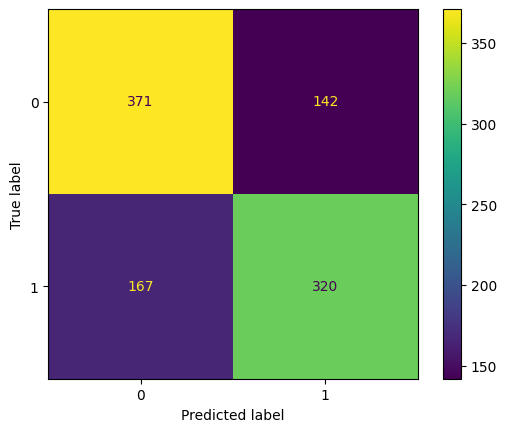

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1]).plot()

In [4]:
import sklearn.metrics
ACC = (tp + tn) / (tp + tn + fp + fn) # accuracy
ppv = tp / (fp + tp) # positive predictive value or precision
fnr = fn / (fn + tp) # false negative rate or 1 - recall
fpr = fp / (tn + fp) # false positive rate  

ACC, ppv, fnr, fpr

(0.691, 0.6926406926406926, 0.34291581108829566, 0.27680311890838205)

In [5]:
# intervals for FPR via Wilson score intervals
from scipy.stats import binomtest

subdf = y_pred[y_true == 0]
result = binomtest(k=np.sum(y_true != y_pred),
                   n=subdf.shape[0]) 
wilson_ci = result.proportion_ci(confidence_level=0.95, method='wilson')
print(wilson_ci)

ConfidenceInterval(low=0.5593781025935843, high=0.6437789743165853)


## Cross-entropy Loss, Brier Score

### Theoretical Background
Cross-entropy loss and Brier score are defined as follows: 
$$
CE = \mathbb{E}_P[Y\log s(X) + (1 - Y) \log(1 - s(X))], \quad BS = \mathbb{E}_P[(s(X) - Y)^2].
$$
Their empirical estimators are given by
$$
\widehat{CE} = -\frac{1}{n}\sum_{i=1}^n \left[Y_i\log(s(X_i)) + (1 - Y_i)\log(1 - s(X_i))\right], \quad \widehat{BS} = \frac{1}{n}\sum_{i=1}^n (s(X_i) - Y_i)^2.
$$

As before, these metrics are averages of iid observations. Thus, as $n\rightarrow\infty$, we have
$$ 
\sqrt{n}\frac{\widehat{CE} -
CE}{\sqrt{\text{Var}(\widehat{CE})}}\stackrel{d}{\rightarrow}N\left(0, 1\right),
\quad \sqrt{n}\frac{\widehat{BS} -
BS}{\sqrt{\text{Var}(\widehat{BS})}}\stackrel{d}{\rightarrow}N\left(0, 1\right)
$$ 
by the central limit theorem. 
As we showed above, we can use this limiting distribution to obtain confidence intervals for $CE$ and $BS$. 

Again, the Normal approximation can be poor for
small sample sizes. $CE$ and $BS$ are not Binomial proportions, so we cannot use Wilson intervals. 
Instead, using intervals based on the _Student's t-distribution_ is recommended. 


### Implementation
Let's compute an estimate of the cross-entropy loss and construct its confidence intervals using the Student's t-distribution. 

In [6]:
def compute_cross_entropy_loss(y, s):
    return - (y * np.log(s) + (1 - y) * np.log(1 - s))

metric_value_per_observation = compute_cross_entropy_loss(y_true, s)
tstudent_ci = stats.t.interval(confidence=0.95, df=len(y_true) - 1, loc=np.mean(metric_value_per_observation), scale=np.std(metric_value_per_observation) / np.sqrt(len(y_true)))
tstudent_ci

(0.6091185423007969, 0.6297473017327525)

## F1-score

### Theoretical Background
The F1-score is defined as follows:
$$
F_1 = \frac{2}{\mathbb{E}_P[\hat Y | Y =1 ]^{-1} + \mathbb{E}_P[Y | \hat Y = 1]^{-1}}.
$$
Its empirical estimator is given by
$$
\widehat{F_1} =  \frac{2}{\left(\sum_{i: Y_i=1} \hat Y_i\right)^{-1} + \left(\sum_{i: \hat Y_i = 1} Y_i\right)^{-1}}.
$$
Recall and precision, which are the two terms in the denominator, are asymptotically normal.
By the Delta method, we can show that $F_1$ is asymptotically normal as well.
Thus, we can construct confidence intervals using
this approximation. 

However, the intervals based on this approxiamtion require us 
to estimate the variance of the $F_1$ estimator.
This estimation is not straightforward. 
One way to do so is by using the _bootstrap_. The standard bootstrap, which involves resampling with replacement from the dataset multiple times and computing the $F_1$ estimate on each resampled dataset, can provide us with an estimate of the variance. Mathematically, if 
$\hat{F_1}^*(i)$ is the $F_1$ estimate from the $i$-th bootstrapped sample, the variance estimate, $\hat{\sigma}^2$, is given by: 
$$
\hat{\sigma}^2 = \frac{1}{B - 1} \sum_{i=1}^{B} (\hat{F_1}^*(i) - \overline{\hat{F_1}^*})^2 
$$
where $B$ is the total number of bootstrap samples and $\overline{\hat{F_1}^*}$ is the mean of the $F_1$ estimates across all bootstrapped samples."

The bootstrap gives us "for free" a confidence interval for $F_1$. In this notebook, we use the percentile bootstrap. We calculate the $\alpha/2$ and $1 - \alpha/2$ percentiles of the bootstrapped $F_1$ estimates. For a 95% confidence interval, these correspond to the 2.5th and 97.5th percentiles. The interval is given by:
$$
I = (\hat{F_1}^*(\alpha/2), \hat{F_1}^*(1-\alpha/2))
$$
where $\hat{F_1}^*(p)$ is the $p$-th percentile of the bootstrapped $F_1$ scores.


### Implementation

Let's compute the F1 score and construct confidence intervals. 

In [7]:
def compute_f1_score(y, yh):
    cm = metrics.confusion_matrix(y, yh)
    tn, fp, fn, tp = cm.ravel()
    return 2 * tp / (2 * tp + fp + fn)

# Bootstrap Intervals
result_boot = stats.bootstrap(data = (y_true, y_pred), paired = True, 
                              statistic=compute_f1_score, method='percentile',
                              vectorized = False, 
                              confidence_level=0.95, n_resamples=1000, random_state=42)
                              
bootstrap_ci = result_boot.confidence_interval[:2]

# Wald Intervals
f1_score = compute_f1_score(y_true, y_pred)
standard_error_f1_score = np.std(result_boot.bootstrap_distribution) # use the bootstrap distribution to estimate the standard error
wald_ci = stats.norm.interval(confidence=0.95, loc=f1_score,
                                     scale=standard_error_f1_score)

# Student's t-distribution
tdist_ci = stats.t.interval(confidence = 0.95, df=len(y_true)-1, loc=f1_score, scale=standard_error_f1_score)

# we should expect the intervals to be similar
print(bootstrap_ci)
print(wald_ci)
print(tdist_ci)

(0.6393742785686803, 0.707167834835784)
(0.6397831217019387, 0.7090050764013278)
(0.6397411378751069, 0.7090470602281597)


Text(0.5, 1.0, 'F1 Score with 95% Confidence Intervals')

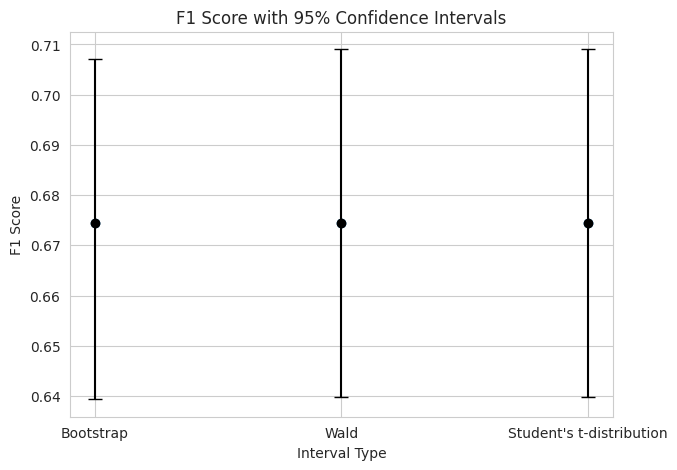

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot confidence intervals
intervals_df = pd.DataFrame({
    'Bootstrap': bootstrap_ci,
    'Wald': wald_ci,
    "Student's t-distribution": tdist_ci
}).T
intervals_df.columns = ['Lower', 'Upper']

sns.set_style('whitegrid')
plt.figure(figsize=(7, 5))
plt.plot(intervals_df.index, [f1_score]*3, 'o', label='F1 Score')

lower_errors = f1_score - intervals_df['Lower']
upper_errors = intervals_df['Upper'] - f1_score
plt.errorbar(x=intervals_df.index, y=[f1_score]*3,
             yerr=[lower_errors, upper_errors], 
             capsize=5, fmt='o', color='black', label='Confidence Intervals')


plt.xlabel('Interval Type')
plt.ylabel('F1 Score')
plt.title('F1 Score with 95% Confidence Intervals')

## ROC Coordinates (TPR@FPR) and AUC

### Theoretical Background

There are two types of intervals for the ROC curve coordinates: [pointwise
intervals](https://archive.nyu.edu/bitstream/2451/27808/2/CPP-06-05.pdf) and
[confidence
bands](https://archive.nyu.edu/jspui/bitstream/2451/27802/2/CPP-07-04.pdf).
Pointwise intervals are constructed to cover a single point on the ROC curve,
i.e., they are constructed around the TPR at a given FPR level. Confidence
bands, instead, are constructed to cover the entire ROC curve at a given level.
In mathematical terms, pointwise intervals and confidence bands are such that 
$$
P_P\left( \text{TPR}@\text{FPR}=\text{fpr}\in I_{pw} \right) = 1-\alpha, \quad P_P\left( ROC\in
I_{cb} \right) = 1-\alpha 
$$ 
where $FPR@FPR$ is the false positive rate at a
given false positive rate level fpr $\in[0,1]$ and $ROC$ is the entire ROC curve, i.e., the
collection of TPR at different FPR levels. Here we focus on pointwise confidence
intervals.

There are [multiple
techniques](https://archive.nyu.edu/bitstream/2451/27808/2/CPP-06-05.pdf) to
construct these intervals and in this example we use vertical averaging. Suppose
that you want to obtain a confidence interval for TPR@FPR=fpr. We bootstrap
resample the test set with replacement and compute TPR@FPR=fpr on each resampled
dataset. As in the percentile bootstrap, we then take the desired percentiles of
the bootstrap distribution of the resampled metrics to obtain the confidence
interval. If we consider a range of fpr's, the above procedure also provides us
with confidence bounds for the area under the curve (AUC). 


### Implementation
Let's see how to compute these intervals. 

In [9]:
# function to calculate the confidence interval for the pointwise confidence
# intervals for the ROC curve and for the intervals for the AUC

def get_perc_boot_int_roc(y_true, y_scores, B=1000, confidence_level=0.95):
    n = len(y_true)
    base_fpr, base_tpr, thresholds = metrics.roc_curve(y_true, y_scores)
    base_auc = metrics.auc(base_fpr, base_tpr)
    
    bootstrapped_roc = []
    bootstrapped_auc = []
    for _ in range(B):
        indices = np.random.choice(range(n), size=n, replace=True)
        y_true_bootstrapped = [y_true[i] for i in indices]
        y_scores_bootstrapped = [y_scores[i] for i in indices]
        
        # Calculate ROC curve
        fpr, tpr, thresholds = metrics.roc_curve(y_true_bootstrapped, y_scores_bootstrapped)
        bootstrapped_roc.append(np.interp(base_fpr, fpr, tpr))
        bootstrapped_auc.append(metrics.auc(fpr, tpr))
        
    # Calculate confidence intervals
    alpha = 1 - confidence_level
    confint_roc = np.percentile(bootstrapped_roc, [alpha/2 * 100, 100 - alpha/2 * 100], axis=0)
    confint_auc = np.percentile(bootstrapped_auc, [alpha/2 * 100, 100 - alpha/2 * 100])
    
    return {
        'fpr': base_fpr,
        'tpr': base_tpr,
        'tpr_lb': confint_roc[0],
        'tpr_ub': confint_roc[1],
        'auc': base_auc,
        'auc_lb': confint_auc[0],
        'auc_ub': confint_auc[1]
    }
    

roc_confint = get_perc_boot_int_roc(
    y_true=y_true,
    y_scores=s,
    B = 1000,
    confidence_level=0.95
)

In [10]:
# show AUC and TPR@FPR=0.01, 0.05, 0.1 with corresponding confidence intervals
def get_tpr_at_fpr(target_fpr, fpr, tpr, tpr_lb, tpr_ub):
    return {
        f'fnr_at_fpr_{target}': [
            np.interp(target, fpr, tpr),
            np.interp(target, fpr, tpr_lb),
            np.interp(target, fpr, tpr_ub)
        ] for target in target_fpr
    }

target_fprs = [0.01, 0.05, 0.1]
stats_summary = roc_confint # TODO: fix

rawtable = {
    'auc': [stats_summary['auc'], stats_summary['auc_lb'], stats_summary['auc_ub']],
    **get_tpr_at_fpr(target_fprs, stats_summary['fpr'], stats_summary['tpr'], stats_summary['tpr_lb'], stats_summary['tpr_ub'])
}

pd.DataFrame([
    ["{:.2f} ({:.2f}, {:.2f})".format(val[0], val[1], val[2]) for val in rawtable.values()]
], columns=['AUC'] + [f'TPR@FPR={target}' for target in target_fprs])

,AUC,TPR@FPR=0.01,TPR@FPR=0.05,TPR@FPR=0.1
0,"0.76 (0.73, 0.79)","0.11 (0.05, 0.16)","0.28 (0.18, 0.38)","0.44 (0.34, 0.50)"


/mnt/efs/themis-shared/fogliato/.conda/conformal/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/efs/themis-shared/fogliato/.conda/conformal/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/efs/themis-shared/fogliato/.conda/conformal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/efs/themis-shared/fogliato/.conda/conformal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning

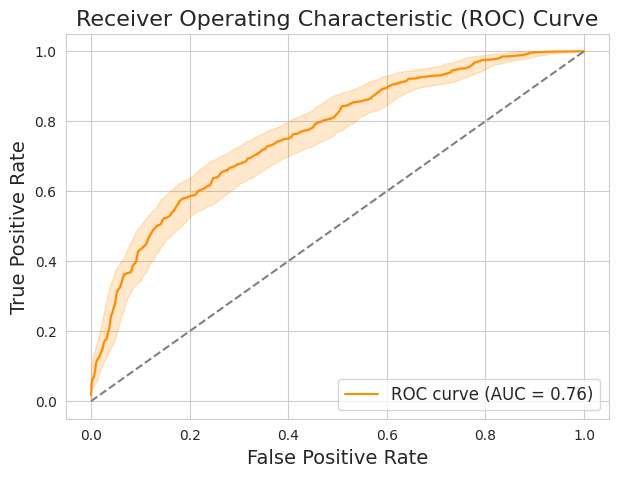

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configure plot
sns.set_style('whitegrid')
plt.figure(figsize=(7, 5))

# Plot ROC curve and diagonal line directly using the original data
sns.lineplot(x=roc_confint['fpr'], y=roc_confint['tpr'], color='darkorange', label=f'ROC curve (AUC = {roc_confint["auc"]:.2f})')
sns.lineplot(x=[0, 1], y=[0, 1], color='gray', linestyle='--')

# Fill area for confidence interval without adding it to the legend
plt.fill_between(roc_confint['fpr'], roc_confint['tpr_lb'], roc_confint['tpr_ub'], alpha=0.2, color='darkorange')

# Labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)

# Confidence Intervals on Dependent Data

Unfortunately, the assumption of data independence does not always hold. For
example, in time series, events that are close in time are correlated; the
outcomes of kids in the same classroom are associated; and the performances of
individuals belonging to the same team are associated. Thus, information about
this clustering needs to be taken into account in the uncertainty computations.


## Interval Construction with Clustering along One Dimension

### Theoretical Background
Let's first look at the case of clustering in one dimension. Consider the following data-generating process with $g$ groups and $n$ observations per group:
$$
C_{i} \sim \text{Uniform}(0,1)\\
X_{ij} \sim \mathcal{N}(C_{1, i}, 1) \\
Y_{ij} \sim \text{Bernoulli}((1 + e^{-X_{ij}})^{-1})
$$
for $1\leq i\leq n$ and $1\leq j\leq g$. Note that there is clustering in one only dimension, i.e., each observation belongs to the group defined by $C_i$ and that group only. Indeed, it is easy to see that the observations within the same group are dependent: 
$\mathbb{E}_P[Y_{11}Y_{12}]\neq \mathbb{E}_P[Y_{11}]\mathbb{E}_P[Y_{12}]$. It follows that 
$$
\text{Var}\left(\frac{1}{ng}\sum_{j=1}^g \sum_{i=1}^n Y_{i1}\right) = \frac{1}{g}\text{Var} \left(\frac{1}{n}\sum_{i=1}^n Y_{1i}\right)
$$
where the equality follows from the assumptions that observations are independent across groups and the distributions of $Y_{ij}$ are identical across groups. However,  
$$
\frac{1}{gn^2}\text{Var} \left(\sum_{i=1}^n Y_{1i}\right) = \frac{1}{gn}\left(\text{Var} \left(Y_{11}\right) + (n-1)\text{Cov} \left(Y_{11}, Y_{12}\right)\right)\geq \frac{1}{gn}\text{Var} \left(Y_{11}\right)
$$
It follows that the intervals constructed in the previous section under the IID assumption are not valid here.

Thus, how can we construct valid intervals in this setting? There are two main approaches:
* Intervals on dependent data: If you plan to work directly on a dataset with
  dependent observations, you have to account for data dependence in the
  construction of the confidence intervals. In parametric methods, you need to
  compute the dependence explicitly. For example, if we let $g\rightarrow\infty$, then $\sqrt{g}\sum_{ij}Y_{ij}/(ng)$ is asymptotically normal and we can construct confidence intervals for it. However, if $n$ is large enough, we have $\text{Var}(\sum_{j=1}^n Y_{1j})\approx \text{Cov}(Y_{11}, Y_{12})$, which needs to be estimated to compute the intervals. In nonparametric methods, you need to resample at the most coarse level of clustering. When a group is sampled in a given bootstrap iteration, you may either choose to select directly all observations corresponding to a given group when that group is resampled or to resample within the group as well. 
* Pursuing data independence: Alternatively, you can modify the data by aggregating
  observations within the respective clusters to obtain a dataset of independent
  observations and then apply the methods that we have already reviewed. That is, compute $\bar{Y}_i = \frac{1}{n}\sum_{i=1}^n Y_{ij}$
  and use this new dataset to construct confidence intervals. 

### Implementation

Let's generate data from the above process and construct confidence intervals for the performance metrics of a classifier that estimates $Y$. We will use the bootstrap to construct the intervals, using both approaches outlined above. 

In [12]:
def generate_data_clustering_one_dimension(num_clusters=50, num_obs_per_cluster=10):
    C_i = np.random.randint(1, num_clusters + 1, size=num_obs_per_cluster * num_clusters)
    X_ij = np.zeros(num_obs_per_cluster * num_clusters)
    Y_ij = np.zeros(num_obs_per_cluster * num_clusters, dtype=int)
    S_ij = np.zeros(num_obs_per_cluster * num_clusters)

    for i in range(num_obs_per_cluster * num_clusters):
        cluster_mean = C_i[i]
        X_ij[i] = np.random.normal(cluster_mean, 1)
        p = 1 / (1 + np.exp(-X_ij[i]))
        Y_ij[i] = np.random.binomial(1, p) 
        S_ij[i] = 1 / (1 + np.exp(-0.4 * X_ij[i]))

    return C_i, Y_ij, np.array([1 if S_ij[i] > 0.5 else 0 for i in range(len(S_ij))]), S_ij

c, y_true, y_pred, s = generate_data_clustering_one_dimension()

In [13]:
# Number of groups
K = len(set(c))
print(f'Number of groups: {K}')

Number of groups: 50


In [14]:
# Percentile bootstrap interval with grouping to construct intervals for accuracy
def get_percentile_bootstrap_interval(data, statistic=np.mean, B=1000, confidence_level=0.95, group=None):
    alpha = 1 - confidence_level
    bootstrap_values = np.empty(B)
    
    # Precompute group indices if groups are provided
    if group is not None:
        group_indices = {g: np.where(group == g)[0] for g in np.unique(group)}
    
    for i in tqdm(range(B)):
        if group is not None:
            sampled_groups = np.random.choice(list(group_indices.keys()), size=len(group_indices), replace=True)
            sampled_indices = np.concatenate([group_indices[g] for g in sampled_groups])
            bootstrapped_values = data[sampled_indices]
        else:
            bootstrapped_values = np.random.choice(data, size=len(data), replace=True)
        
        bootstrap_values[i] = statistic(bootstrapped_values)
    
    lower_percentile = np.percentile(bootstrap_values, alpha / 2 * 100)
    upper_percentile = np.percentile(bootstrap_values, (1 - alpha / 2) * 100)
    
    return [lower_percentile, upper_percentile]

# Group by cluster in the interval construction
boot_interval1 = get_percentile_bootstrap_interval(y_true == y_pred, statistic=np.mean, group=c)

# Process the dataset and then compute the interval
acc_by_cluster = [np.mean(y_true[c == group] == y_pred[c == group]) for group in np.unique(c)]
boot_interval2 = get_percentile_bootstrap_interval(acc_by_cluster, statistic=np.mean)
tstudent_ci = stats.t.interval(confidence=0.95, df=len(acc_by_cluster) - 1, loc=np.mean(acc_by_cluster), scale=np.std(acc_by_cluster) / np.sqrt(len(acc_by_cluster)))

# As expected, the intervals are similar
print("Bootstrap Interval, dealing with dependent data:", boot_interval1)
print("Bootstrap Interval, pursuing independence:", boot_interval2)
print("T-Student Interval, pursuing independence:", tstudent_ci)

100%|██████████| 1000/1000 [00:00<00:00, 43066.65it/s]

Bootstrap Interval, dealing with dependent data: [0.9651735323842582, 0.9980323527619976]
Bootstrap Interval, pursuing independence: [0.9693066239316239, 0.9977777777777778]
T-Student Interval, pursuing independence: (0.9709802891572887, 1.0003444971674977)


## Interval Construction with Clustering along Two Dimensions

Unfortunately, things can be a bit more complex. For example, Netflix users rate
multiple movies and movies are watched by multiple users. As another example,
one patient can be seen by multiple doctors and a doctor may see multiple
patients. We can represent this setting as a matrix where columns and rows
correspond to two distinct variables, which identify the clusters, and the cells
contain the corresponding observations. 


### Theoretical Background

Imagine that the data-generating process is as follows:
$$
Z_i \sim \text{Uniform}(0, 1)\\
Q_{j} \sim \text{Uniform}(0, 1)\\
X_{ij} \sim \mathcal{N}(Z_i + Q_j, 1) \\
Y_{ij} \sim \text{Bernoulli}((1 + e^{-X_{ij}})^{-1})
$$
for $1\leq i\leq z$ and $1\leq j\leq q$. Here, $Z_i$ and $Q_j$ are the two variables that identify the clusters. Note that there is clustering in two dimensions, i.e., each observation belongs to the group defined by $Z_i$ and $Q_j$. You can imagine that you might even have multiple observations for each cluster. 

Alright, then how do we compute confidence intervals here? As usual, we can use
either parametric or nonparametric methods. Let's focus here only on
nonparametric methods and more specifically on the bootstrap. One specific
method, which is known as the _pigeonhole bootstrap_, consists of independently
resampling rows (e.g., doctors) and columns (e.g., patients). This procedure
will yield conservative intervals; see [this
paper](https://www.jstor.org/stable/3318577) and [this other
paper](https://projecteuclid.org/journals/annals-of-applied-statistics/volume-1/issue-2/The-pigeonhole-bootstrap/10.1214/07-AOAS122.full).
A related procedure, known as the _double-or-nothing bootstrap_, consists of
reweighing rows and columns with iid weights sampled from Uniform({0,2})
([here](https://projecteuclid.org/journals/annals-of-applied-statistics/volume-6/issue-3/Bootstrapping-data-arrays-of-arbitrary-order/10.1214/12-AOAS547.full)).
Let's implement and compare the two procedures below. 


### Implementation


In [15]:
# Data generation

def generate_data_clustering_two_dimensions(z=50, q=50):
    Z_i = np.random.uniform(0, 1, size=z)
    Q_j = np.random.uniform(0, 1, size=q)
    X_ij = np.zeros((z, q))
    Y_ij = np.zeros((z, q), dtype=int)
    S_ij = np.zeros((z, q))

    for i in range(z):
        for j in range(q):
            X_ij[i, j] = np.random.normal(Z_i[i] + Q_j[j], 1)
            p = 1 / (1 + np.exp(-X_ij[i, j]))
            Y_ij[i, j] = np.random.binomial(1, p)
            S_ij[i, j] = 1 / (1 + np.exp(-0.4 * X_ij[i, j]))
            
    y_pred = np.array([[1 if S_ij[i, j] > 0.5 else 0 for j in range(q)] for i in range(z)])

    return Z_i, Q_j, X_ij, Y_ij, y_pred, S_ij

z, q, x, y_true, y_pred, s = generate_data_clustering_two_dimensions()

In [16]:
# Confidence intervals for accuracy via bootstrap
def get_dataarrays_bootstrap(data, statistic, group1, group2, B=1000, confidence_level=0.95, resampling_type='pigeonhole'):
    alpha = 1 - confidence_level
    unique_ids1 = np.unique(group1)
    unique_ids2 = np.unique(group2)

    # Transform data into dictionary
    data_dict = {id1: {id2: data[(group1 == id1) & (group2 == id2)] for id2 in group2[group1 == id1]} for id1 in unique_ids1}
    
    bootstrap_samples = np.empty(B)

    for i in tqdm(range(B)):
        if resampling_type == 'pigeonhole':
            resampled_ids1 = np.random.choice(unique_ids1, size=unique_ids1.size, replace=True)
            resampled_ids2 = np.random.choice(unique_ids2, size=unique_ids2.size, replace=True)
        else:  # 'double-or-nothing'
            resampled_ids1 = unique_ids1[np.random.choice([0, 1], size=unique_ids1.size).astype(bool)]
            resampled_ids2 = unique_ids2[np.random.choice([0, 1], size=unique_ids2.size).astype(bool)]

        b_sample = np.concatenate([data_dict[id1][id2] for id1 in resampled_ids1 for id2 in data_dict[id1] if id2 in resampled_ids2])
        
        bootstrap_samples[i] = statistic(b_sample)
        
    lower_bound = np.nanpercentile(bootstrap_samples, alpha / 2 * 100)
    upper_bound = np.nanpercentile(bootstrap_samples, (1 - alpha / 2) * 100)
    return [lower_bound, upper_bound]

metric_value_by_observation = y_true == y_pred
boot_interval1 = get_dataarrays_bootstrap(metric_value_by_observation, np.mean, z, q, resampling_type='pigeonhole')
boot_interval2 = get_dataarrays_bootstrap(metric_value_by_observation, np.mean, z, q, resampling_type='double-or-nothing')

# Intervals are going to be similar
print("Pigeonhole Bootstrap Interval:", boot_interval1)
print("Double-or-nothing Bootstrap Interval:", boot_interval2)

100%|██████████| 1000/1000 [00:00<00:00, 6476.63it/s]

Pigeonhole Bootstrap Interval: [0.7, 0.7466666666666667]
Double-or-nothing Bootstrap Interval: [0.6955416666666667, 0.7525]


# Hypothesis Testing

We often want to test whether the performances of two models $ACC_1$ and $ACC_2$, are different at
the population level, that is, 
* $H_0$: Model performances match (on the population), i.e., $ACC_1 = ACC_2$. 
* $H_1$: Model performances do not match (on the population), i.e., $ACC_1 \neq ACC_2$. 
$H_0$ and $H_1$ are known as the null and alternative hypotheses, respectively.
In this case, $H_0$ contains only one value and is known as a _simple hypothesis_. 

Another example is testing whether the performance of a model is equal to values in a certain range, that is,
* $H_0$: Model performance is equal to some value within $[a, b]$ (on the population), i.e., $ACC_1 \in [a,b]$.
* $H_1$: Model performance does not fall in the range $[a,b]$ (on the population). i.e., $ACC_1 \not\in [a,b]$. 
In this case, $H_0$ contains multiple values and is known as a _composite hypothesis_.

Hypothesis testing and confidence intervals are closely intertwined. They serve
complementary purposes in statistical analysis, with hypothesis testing
evaluating the evidence against a specific hypothesis, and confidence intervals
providing an estimated range of plausible values for a population parameter.

### Theoretical Background

There is a lot to say about hypothesis testing. I'll assume that you are
familiar with the basics. If not, you can find a good introduction
[here](https://www.stat.cmu.edu/~larry/=stat705/Lecture16.pdf). Essentially, conducting a hypothesis test involves the following steps:
Let's add mathematical examples to each of the five steps in hypothesis testing:

1. **Formulate the Null and Alternative Hypotheses**:
   - Example: Testing the difference in accuracies of two models.
     - $H_0$: $ACC_1 = ACC_2$ (the models have equal accuracy).
     - $H_1$: $ACC_1 \neq ACC_2$ (the models have different accuracies).

2. **Choose a Test Statistic**:
   - Example: Using a t-test for comparing two means.
     - Test Statistic: $t = \frac{\widehat{ACC}_1 - \widehat{ACC}_2}{\sqrt{\text{Var}(\widehat{ACC}_1) + \text{Var}(\widehat{ACC}_2)}}$.

3. **Choose a Significance Level, $\alpha$**:
   - Example: Choosing a 5% significance level.
     - $\alpha = 0.05$ (There is a 5% chance of rejecting the null hypothesis when it is actually true).

4. **Compute the p-value**:
   - Example: Calculating the p-value from the t-test.
     - p-value = $\mathbb{P}(T > |t|)$ for a two-tailed test, where $T$ follows a t-distribution with degrees of freedom based on $n_1$ and $n_2$.

5. **Reject the Null Hypothesis if the p-value is Less Than $\alpha$**:
   - Example: Decision making based on the p-value.
     - If p-value $< 0.05$, reject $H_0$; otherwise, do not reject $H_0$.


We now show how to conduct some tests to assess equality of the performance of
two models. At a high level, tests can be divided into parametric and
nonparametric. What you can use may depend on the type of the metric considered
and on the nature of the dataset. 

_Remember to decide which test to use and the significance level before looking at the data!_

### Implementation

Let's see a couple of examples but first let's create two datasets.

In [17]:
y_true1, y_pred1, s1 = generate_data_iid(sample_size = 50)
y_true2, y_pred2, s2 = generate_data_iid(sample_size = 100)

We want to test whether difference in performance, or equivalently in error rates, across two groups is statistically significant. Thus, our test will be:

* $H_0$: Model performances match (on the population). 
* $H_1$: Model performances do not match (on the population). 


#### Binary Accuracy, FPR, FNR, PPV

Say that we want to test the difference in the binary accuracies of the two
models. In order to do so, we'll use Barnard's test, which is a nonparametric
test that is based for contingency tables. Note that in our example the model
predictions are generated for different test sets. If the models are tested on
the same dataset, you should use a paired t-test instead.

In [18]:
errors1 = np.sum(y_true1 != y_pred1)
n1 = len(y_true1)
errors2 = np.sum(y_true2 != y_pred2)
n2 = len(y_true2)

stats.barnard_exact([[errors1, n1], [errors2, n2]], alternative="two-sided")

BarnardExactResult(statistic=0.16858600833184026, pvalue=0.8994349434544565)

####  Brier Score and Cross-entropy Loss
We now want to test the difference in the cross-entropy loss of the two models. Let's use a t-test for independent samples. Keep in mind that, as before, if you have model predictions on the same test set, you should use a paired t-test instead.

In [19]:
obs1 = compute_cross_entropy_loss(y_true1, s1)
obs2 = compute_cross_entropy_loss(y_true2, s2)

stats.ttest_ind(obs1, obs2, equal_var = False, alternative='two-sided')

TtestResult(statistic=-0.6489704839171431, pvalue=0.5178052318322435, df=102.76115483602429)

Alternatively, you can use a permutation test. This will give similar results for large samples, but it is more robust to violations of the normality assumption. However, it can be very slow. 

In [20]:
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

# stats.permutation_test((obs1, obs2), statistic, vectorized=True,
#                        n_resamples=np.inf, alternative='two-sided')

#### F1-score And ROC Coordinates (aka TPR@FPR) And AUC

For the remaining metrics, we can use the bootstrap or permutation tests. For the comparison of AUCs, we can use [DeLong's test](https://github.com/yandexdataschool/roc_comparison), which is specifically designed for this purpose. 

<!-- Let's see an example of a bootstrap procedure for the TPR@FPR=0.1.  -->

## Testing the Equality of Multiple Metrics

### Theoretical Background

When evaluating multiple models, we often want to test if there are any statistically significant differences in their performance metrics. This process involves multiple hypothesis tests, but it raises a concern: the more tests we conduct, the higher the chance of encountering a false positive, or a Type I error (incorrectly rejecting a true null hypothesis).

The Family-Wise Error Rate (FWER) is the probability of making at least one Type I error across all the tests. It's crucial to control the FWER to maintain the reliability of our statistical conclusions. Mathematically, FWER is defined as:
$$
FWER = P\left(\bigcup_{i=1}^n \{\text{reject } H_0^i | H_0^i \text{ is true}\}\right).
$$
Clearly, if we conduct $n$ independent tests, the probability of making at least one Type I error is $1 - (1 - \alpha)^n$, which increases with $n$. Thus, we need to adjust the significance level for each test to ensure that the FWER is controlled.

A common approach to controlling the FWER is the Bonferroni correction. This method adjusts the significance level for each individual test, reducing the chances of false discoveries when multiple comparisons are made. If we perform $m$ tests and wish to keep the overall Type I error rate or FWER at a significance level $\alpha$, the Bonferroni correction sets the significance level for each test to $\alpha/m$.


Suppose we have three datasets and three corresponding models, resulting in three performance comparisons. To apply the Bonferroni correction:

- If our desired overall significance level is $\alpha = 0.05$, then for each individual test, the Bonferroni-corrected significance level would be $\alpha/3 = 0.05/3 \approx 0.0167$.
- Each hypothesis test comparing the performance of the models will be evaluated against this adjusted significance level.
- This ensures that the collective probability of making at least one Type I error in these three tests is controlled and does not exceed 0.05.

By using the Bonferroni correction, we can conduct multiple hypothesis tests while safeguarding against the inflation of Type I error rates, ensuring more robust and reliable statistical analysis.

### Implementation

In [21]:

y_true1, y_pred1, s1 = generate_data_iid()
y_true2, y_pred2, s2 = generate_data_iid()
y_true3, y_pred3, s3 = generate_data_iid()


def get_stats(y_true, y_pred):
    errors = (y_true != y_pred).sum()
    correct = len(y_true) - errors
    return [errors, correct]

# List of tuples of true and predicted values
data = [(y_true1, y_pred1), (y_true2, y_pred2), (y_true3, y_pred3)]

# Perform Barnard's Exact Test
results = []
for i in range(2):
    for j in range(i + 1, 3):
        test_result = stats.barnard_exact([get_stats(*data[i]), get_stats(*data[j])])
        results.append(((i, j), test_result.pvalue))

print(results)

# Bonferroni Correction
alpha_bonferroni = 0.05 / len(results)

# Results Interpretation
for model_combination, p_value in results:
    if p_value < alpha_bonferroni:
        print(f"Null hypothesis rejected for models {model_combination} with p-value {p_value}")
    else:
        print(f"Null hypothesis not rejected for models {model_combination} with p-value {p_value}")

[((0, 1), 0.23316695017696668), ((0, 2), 0.007835208137128359), ((1, 2), 0.1461020153803968)]
Null hypothesis not rejected for models (0, 1) with p-value 0.23316695017696668
Null hypothesis rejected for models (0, 2) with p-value 0.007835208137128359
Null hypothesis not rejected for models (1, 2) with p-value 0.1461020153803968


# If the Confidence Intervals Overlap, can we Conclude that the Difference is not Statistically Significant? (No!)

If $1-\alpha$ confidence intervals around two performance estimates overlap, you _cannot_ conclude that the difference between the two performances is not statistically significant at the $\alpha$ level. Reversely, if they do not overlap, you can conclude that the difference is statistically significant. 

To reiterate, rejection of the null hypothesis by the overlap method implies rejection by the corresponding hypothesis testing procedure, but not vice versa. In other words, the method of judging statistical significance via confidence intervals is more conservative and less powerful than the corresponding hypothesis test. 

Let's see the discussion in [this paper](https://www.tandfonline.com/doi/abs/10.1198/000313001317097960) to get a sense of why that's the case. Assume that you have the $1-\alpha$ confidence intervals for the accuracies of two classifiers: 
$$
\widehat{ACC}_1 \pm z_{1-\alpha/2} \sqrt{\text{Var}(\widehat{ACC}_1)}, \quad \widehat{ACC}_2 \pm z_{1-\alpha/2} \sqrt{\text{Var}(\widehat{ACC}_2)}
$$
and you wish to test whether $ACC_1 - ACC_2 = 0$. By looking at the overlap of the intervals, you are essentially testing whether the following event occurs:
$$
\widehat{ACC}_1 - \widehat{ACC}_2 \pm z_{1-\alpha/2} \left(\sqrt{\text{Var}(\widehat{ACC}_1)} + \sqrt{\text{Var}(\widehat{ACC}_2)} \right). 
$$
However, the correct confidence interval for $ACC_1 - ACC_2$ is actually given by 
$$
\widehat{ACC}_1 - \widehat{ACC}_2 \pm z_{1-\alpha/2} \sqrt{\text{Var}(\widehat{ACC}_1) + \text{Var}(\widehat{ACC}_2)}.
$$
Note that
$$
\sqrt{\text{Var}(\widehat{ACC}_1) + \text{Var}(\widehat{ACC}_2)}\leq \sqrt{\text{Var}(\widehat{ACC}_1)} + \sqrt{\text{Var}(\widehat{ACC}_2)}
$$
by the Cauchy-Schwarz inequality. Thus, the confidence interval for $ACC_1 - ACC_2$ is contained in the interval that we are testing for. In other words, the overlap method is conservative.

Thus remember that, when testing for statistical significance, you should prefer the use of hypothesis testing than the overlap of confidence intervals. Use confidence intervals only to get an idea of the magnitude of the difference between the two performances.

# Two-sided vs. One-sided Confidence Intervals and Hypothesis Testing

### Theoretical Background

Until this section, we have focused on two-sided confidence intervals and hypothesis testing. This approach is apt when our objective is to detect deviations from a central value in either direction. 

However, there are instances where our hypotheses are inherently directional, prompting the need for one-sided tests and intervals. This scenario is particularly relevant when we aim to establish whether a parameter surpasses or falls below a specific benchmark.

Consider, for instance, the evaluation of a model's error rate against a set threshold, c. The hypotheses in this case would be:

- $H_0$: $ACC\leq c$.
- $H_1$: $ACC > c$.

For one-sided confidence intervals, we focus solely on the boundary pertinent to our hypothesis:

- _Upper One-sided Interval_: For a 95% upper one-sided confidence interval of a Gaussian estimator, we locate the point at the 95th percentile. The lower bound is $-\infty$.
- _Lower One-sided Interval_: Conversely, for a lower interval, we identify the point below which 95% of the distribution lies, with the upper bound being $\infty$.

One-sided confidence intervals and hypothesis tests are essential when our research questions or hypotheses are directional. They offer a focused statistical analysis, particularly useful when deviations in one specific direction from a standard or threshold are of primary concern.

### Implementation

Applying these principles to the Brier score, we can construct a one-sided interval to determine if the score is acceptably low. This interval informs us about the range within which the true Brier score is likely to fall, assuming a certain confidence level and model accuracy.

In [23]:
# Upper one-sided intervals for Brier Score
def compute_brier_score(y, s):
    return (y - s) ** 2

y_true, y_pred, s = generate_data_iid()

metric_value_per_observation = compute_brier_score(y_true, s)

# t-student interval
tstudent_ci = stats.t.interval(confidence=0.90, df=len(s) - 1, loc=np.mean(metric_value_per_observation), scale=np.std(metric_value_per_observation) / np.sqrt(len(s)))
tstudent_ci = (-np.inf, tstudent_ci[1]) # 0.95 confidence level


bootstrap_ci = stats.bootstrap((metric_value_per_observation,), statistic=np.mean, method='percentile',
                                confidence_level=0.9, n_resamples=1000,
                                random_state=np.random.default_rng()).confidence_interval[:2]
bootstrap_ci = (-np.inf, bootstrap_ci[1]) # 0.95 confidence level


print("Student's t-distribution Interval:", tstudent_ci)
print("Bootstrap Interval:", bootstrap_ci)

Student's t-distribution Interval: (-inf, 0.22216610156148855)
Bootstrap Interval: (-inf, 0.2220122432241553)
